# Successive halving - CNN

In this notebook, will use successive halving to stop the training of suboptimal neural network configurations.

In [1]:
# For reproducible results. See: 
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

import os
os.environ['PYTHONHASHSEED'] = '0'

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

In [2]:
import itertools
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.models import Sequential, load_model
from keras.optimizers import Adam, RMSprop

from tensorflow.keras.utils import to_categorical

In [4]:
import optuna

#  Data Preparation

The dataset contains information about images, each image is a hand-written digit. The aim is to have the computer predict which digit was written by the person, automatically, by "looking" at the image. 

Each image is 28 pixels in height and 28 pixels in width (28 x 28), making a total of 784 pixels. Each pixel value is an integer between 0 and 255, indicating the darkness in a gray-scale of that pixel.

The data is stored in a dataframe where each each pixel is a column (so it is flattened and not in the 28 x 28 format). 

The data set the has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [5]:
# Load the data

data = pd.read_csv("../mnist.csv")

# first column is the target, the rest of the columns
# are the pixels of the image

# each row is 1 image
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['label'], axis=1), # the images
    data['label'], # the target
    test_size = 0.1,
    random_state=0)

X_train.shape, X_test.shape

((37800, 784), (4200, 784))

Text(0, 0.5, 'Number of images')

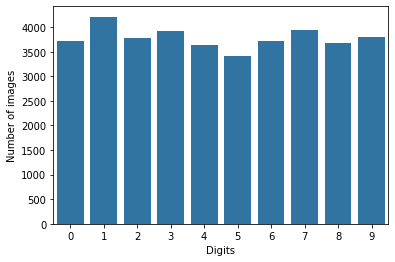

In [7]:
# number of images for each digit

g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

There are roughly the same amount of images for each of the 10 digits.

## Image re-scaling

We re-scale data for the CNN, between 0 and 1.

In [8]:
# Re-scale the data

# 255 is the maximum value a pixel can take

X_train = X_train / 255
X_test = X_test / 255

## Reshape

The images were stored in a pandas dataframe as 1-D vectors of 784 values. For a CNN with Keras, we need tensors with the following dimensions: width x height x channel. 

Thus, we reshape all data to 28 x 2 8 x 1, 3-D matrices. 

The 3rd dimension corresponds to the channel. RGB images have 3 channels. MNIST images are in gray-scale, thus they have only one channel in the 3rd dimension.

In [9]:
# Reshape image in 3 dimensions:
# height: 28px X width: 28px X channel: 1 

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

## Target encoding

In [10]:
# the target is 1 variable with the 9 different digits
# as values

y_train.unique()

array([2, 0, 7, 4, 3, 5, 9, 6, 8, 1], dtype=int64)

In [11]:
# For Keras, we need to create 10 dummy variables,
# one for each digit

# Encode labels to one hot vectors (ex : digit 2 -> [0,0,1,0,0,0,0,0,0,0])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

# the new target
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Let's print some example images.

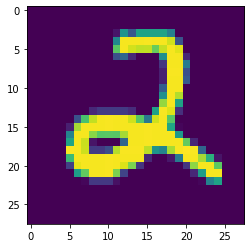

In [12]:
# Some image examples 

g = plt.imshow(X_train[0][:,:,0])

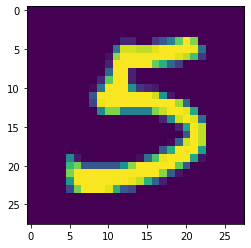

In [13]:
# Some image examples 

g = plt.imshow(X_train[10][:,:,0])

# Define-by-Run design

We create the CNN and add the sampling space for the hyperparameters as we go. This is the design-by-run concept.

In [25]:
# function to create the CNN

def objective(trial):

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # We add the different number of conv layers in the following loop:
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)

    for i in range(num_conv_layers):

        model.add(Conv2D(
            filters=trial.suggest_categorical('filters', [16, 32, 64]),
            kernel_size=trial.suggest_categorical('kernel_size', [3, 5]),
            strides=trial.suggest_categorical('strides', [1, 2]),
            activation=trial.suggest_categorical(
                'activation', ['relu', 'tanh']),
            padding='same',
        ))

    # we could also optimize these parameters if we wanted:
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add the dense fully-connected layer to the model.
    # This has two hyper-parameters we want to optimize:
    # The number of nodes (neurons) and the activation function.
    model.add(Dense(
        units=trial.suggest_int('units', 5, 512),
        activation=trial.suggest_categorical(
            'activation', ['relu', 'tanh']),
    ))

    # Last fully-connected dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    optimizer_name = trial.suggest_categorical(
        'optimizer_name', ['Adam', 'RMSprop'])

    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=trial.suggest_float('learning_rate',  1e-6, 1e-2))
    else:
        optimizer = RMSprop(
            learning_rate=trial.suggest_float('learning_rate',  1e-6, 1e-2),
            momentum=trial.suggest_float('momentum',  0.1, 0.9),
        )

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # the early stopping criteria is the epoch
    for epoch in range(5):
        model.fit(
            x=X_train,
            y=y_train,
            epochs=epoch,
            batch_size=128,
            validation_split=0.1,
        )

        # Get the classification accuracy on the validation-set
        # after the last training-epoch.
        intermediate_accuracy = model.evaluate(X_test, y_test, verbose=0)
        
        # report it so we can keep track and stop if necessary
        trial.report(intermediate_accuracy[1], epoch)
        
        # stop if suboptimal
        if trial.should_prune():
            raise optuna.TrialPruned()

    return  model.evaluate(X_test, y_test, verbose=0)[1]

In [26]:
study = optuna.create_study(
    direction='maximize',
    sampler = optuna.samplers.TPESampler(),
    pruner = optuna.pruners.SuccessiveHalvingPruner(),
)

study.optimize(objective, n_trials=30)

[I 2024-09-23 17:18:19,396] A new study created in memory with name: no-name-9170a6e0-a7e0-46a9-8b07-f7ab128b3fdf


266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8769 - loss: 0.3953 - val_accuracy: 0.9635 - val_loss: 0.1233
Epoch 1/2
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9743 - loss: 0.0822 - val_accuracy: 0.9767 - val_loss: 0.0837
Epoch 2/2
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9872 - loss: 0.0443 - val_accuracy: 0.9709 - val_loss: 0.1099
Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9908 - loss: 0.0315 - val_accuracy: 0.9778 - val_loss: 0.0904
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9919 - loss: 0.0249 - val_accuracy: 0.9770 - val_loss: 0.0933
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9942 - loss: 0.0185 - val_accuracy: 0.9780 - val_loss: 0.0835
Epoch 1/4
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9959 - loss: 0.0132 - val_accuracy: 0.9759 - val_loss: 0.0951
Epoch 2/4
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9947 - loss: 0.0151 - val_accuracy: 0.9738 - val

[I 2024-09-23 17:19:28,434] Trial 0 finished with value: 0.9702380895614624 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 5, 'strides': 1, 'activation': 'tanh', 'units': 147, 'optimizer_name': 'Adam', 'learning_rate': 0.004584248868838366}. Best is trial 0 with value: 0.9702380895614624.


266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 178ms/step - accuracy: 0.8630 - loss: 0.4366 - val_accuracy: 0.9807 - val_loss: 0.0647
Epoch 1/2
266/266 ━━━━━━━━━━━━━━━━━━━━ 62s 233ms/step - accuracy: 0.9815 - loss: 0.0583 - val_accuracy: 0.9767 - val_loss: 0.0801
Epoch 2/2
266/266 ━━━━━━━━━━━━━━━━━━━━ 76s 211ms/step - accuracy: 0.9868 - loss: 0.0428 - val_accuracy: 0.9810 - val_loss: 0.0773
Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 50s 186ms/step - accuracy: 0.9909 - loss: 0.0282 - val_accuracy: 0.9817 - val_loss: 0.0737
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 48s 179ms/step - accuracy: 0.9924 - loss: 0.0217 - val_accuracy: 0.9802 - val_loss: 0.1093
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 44s 165ms/step - accuracy: 0.9908 - loss: 0.0289 - val_accuracy: 0.9831 - val_loss: 0.1013
Epoch 1/4
266/266 ━━━━━━━━━━━━━━━━━━━━ 43s 163ms/step - accuracy: 0.9947 - loss: 0.0185 - val_accuracy: 0.9849 - val_loss: 0.0828
Epoch 2/4
266/266 ━━━━━━━━━━━━━━━━━━━━ 43s 163ms/step - accuracy: 0.9938 - loss: 0.0206 - val_accura

[I 2024-09-23 17:28:03,518] Trial 1 finished with value: 0.9819047451019287 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'units': 154, 'optimizer_name': 'Adam', 'learning_rate': 0.005156276559672926}. Best is trial 1 with value: 0.9819047451019287.


266/266 ━━━━━━━━━━━━━━━━━━━━ 134s 499ms/step - accuracy: 0.7722 - loss: 0.8880 - val_accuracy: 0.9265 - val_loss: 0.2507


[I 2024-09-23 17:30:28,132] Trial 2 pruned. 


266/266 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.8090 - loss: 0.9696 - val_accuracy: 0.9577 - val_loss: 0.1489


[I 2024-09-23 17:30:42,596] Trial 3 pruned. 


266/266 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7958 - loss: 0.8023 - val_accuracy: 0.9701 - val_loss: 0.1095


[I 2024-09-23 17:30:57,257] Trial 4 pruned. 


266/266 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.7914 - loss: 0.8093 - val_accuracy: 0.9511 - val_loss: 0.1684


[I 2024-09-23 17:31:13,339] Trial 5 pruned. 


266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8411 - loss: 0.5082 - val_accuracy: 0.9302 - val_loss: 0.2250


[I 2024-09-23 17:31:18,194] Trial 6 pruned. 


266/266 ━━━━━━━━━━━━━━━━━━━━ 160s 595ms/step - accuracy: 0.8094 - loss: 0.6439 - val_accuracy: 0.9476 - val_loss: 0.1783


[I 2024-09-23 17:34:11,631] Trial 7 pruned. 


266/266 ━━━━━━━━━━━━━━━━━━━━ 46s 167ms/step - accuracy: 0.8528 - loss: 0.4808 - val_accuracy: 0.9677 - val_loss: 0.1052
Epoch 1/2
266/266 ━━━━━━━━━━━━━━━━━━━━ 45s 168ms/step - accuracy: 0.9782 - loss: 0.0728 - val_accuracy: 0.9754 - val_loss: 0.0895
Epoch 2/2
266/266 ━━━━━━━━━━━━━━━━━━━━ 45s 167ms/step - accuracy: 0.9873 - loss: 0.0410 - val_accuracy: 0.9775 - val_loss: 0.0842
Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 45s 168ms/step - accuracy: 0.9916 - loss: 0.0284 - val_accuracy: 0.9772 - val_loss: 0.0858
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 60s 225ms/step - accuracy: 0.9897 - loss: 0.0309 - val_accuracy: 0.9775 - val_loss: 0.0897
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 183ms/step - accuracy: 0.9863 - loss: 0.0389 - val_accuracy: 0.9630 - val_loss: 0.1369
Epoch 1/4
266/266 ━━━━━━━━━━━━━━━━━━━━ 62s 232ms/step - accuracy: 0.9817 - loss: 0.0534 - val_accuracy: 0.9772 - val_loss: 0.0963
Epoch 2/4
266/266 ━━━━━━━━━━━━━━━━━━━━ 48s 182ms/step - accuracy: 0.9817 - loss: 0.0531 - val_accura

[I 2024-09-23 17:42:39,776] Trial 8 pruned. 


266/266 ━━━━━━━━━━━━━━━━━━━━ 98s 362ms/step - accuracy: 0.4912 - loss: 1.8580 - val_accuracy: 0.9288 - val_loss: 0.2510


[I 2024-09-23 17:44:24,877] Trial 9 pruned. 


266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6923 - loss: 0.9831 - val_accuracy: 0.9413 - val_loss: 0.1920


[I 2024-09-23 17:44:35,311] Trial 10 pruned. 


266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8530 - loss: 0.4568 - val_accuracy: 0.9690 - val_loss: 0.1064


[I 2024-09-23 17:44:42,327] Trial 11 pruned. 


266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8810 - loss: 0.3696 - val_accuracy: 0.9741 - val_loss: 0.0922
Epoch 1/2
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9805 - loss: 0.0625 - val_accuracy: 0.9762 - val_loss: 0.0919
Epoch 2/2
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9867 - loss: 0.0394 - val_accuracy: 0.9788 - val_loss: 0.0758
Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9913 - loss: 0.0282 - val_accuracy: 0.9733 - val_loss: 0.1210
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9912 - loss: 0.0254 - val_accuracy: 0.9765 - val_loss: 0.1040
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9936 - loss: 0.0186 - val_accuracy: 0.9788 - val_loss: 0.1125
Epoch 1/4
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9951 - loss: 0.0144 - val_accuracy: 0.9757 - val_loss: 0.1210
Epoch 2/4
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9948 - loss: 0.0142 - val_accuracy: 0.9757 - val

[I 2024-09-23 17:45:47,377] Trial 12 finished with value: 0.9833333492279053 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'units': 144, 'optimizer_name': 'Adam', 'learning_rate': 0.006699327740534847}. Best is trial 12 with value: 0.9833333492279053.


266/266 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.8679 - loss: 0.4453 - val_accuracy: 0.9754 - val_loss: 0.0784
Epoch 1/2
266/266 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - accuracy: 0.9816 - loss: 0.0558 - val_accuracy: 0.9733 - val_loss: 0.0955
Epoch 2/2
266/266 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.9880 - loss: 0.0362 - val_accuracy: 0.9823 - val_loss: 0.0820
Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.9903 - loss: 0.0289 - val_accuracy: 0.9825 - val_loss: 0.0919
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - accuracy: 0.9926 - loss: 0.0229 - val_accuracy: 0.9815 - val_loss: 0.1135
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 23s 86ms/step - accuracy: 0.9922 - loss: 0.0241 - val_accuracy: 0.9828 - val_loss: 0.1063
Epoch 1/4
266/266 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step - accuracy: 0.9922 - loss: 0.0294 - val_accuracy: 0.9812 - val_loss: 0.1253
Epoch 2/4
266/266 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - accuracy: 0.9940 - loss: 0.0208 - val_accuracy: 0.97

[I 2024-09-23 17:50:01,897] Trial 13 pruned. 


266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8225 - loss: 0.5378 - val_accuracy: 0.9661 - val_loss: 0.1182


[I 2024-09-23 17:50:08,238] Trial 14 pruned. 


266/266 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.8794 - loss: 0.4213 - val_accuracy: 0.9698 - val_loss: 0.0904
Epoch 1/2
266/266 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.9821 - loss: 0.0612 - val_accuracy: 0.9720 - val_loss: 0.0981
Epoch 2/2
266/266 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - accuracy: 0.9880 - loss: 0.0350 - val_accuracy: 0.9788 - val_loss: 0.0912
Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9881 - loss: 0.0359 - val_accuracy: 0.9762 - val_loss: 0.1102
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.9899 - loss: 0.0314 - val_accuracy: 0.9802 - val_loss: 0.1130
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9927 - loss: 0.0246 - val_accuracy: 0.9812 - val_loss: 0.1261
Epoch 1/4
266/266 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.9928 - loss: 0.0255 - val_accuracy: 0.9786 - val_loss: 0.1807
Epoch 2/4
266/266 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.9920 - loss: 0.0291 - val_accuracy: 0.98

[I 2024-09-23 17:52:29,677] Trial 15 pruned. 


266/266 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - accuracy: 0.8454 - loss: 0.4714 - val_accuracy: 0.9762 - val_loss: 0.0787
Epoch 1/2
266/266 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - accuracy: 0.9813 - loss: 0.0577 - val_accuracy: 0.9796 - val_loss: 0.0696
Epoch 2/2
266/266 ━━━━━━━━━━━━━━━━━━━━ 31s 115ms/step - accuracy: 0.9873 - loss: 0.0397 - val_accuracy: 0.9831 - val_loss: 0.0712
Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - accuracy: 0.9897 - loss: 0.0319 - val_accuracy: 0.9839 - val_loss: 0.0669
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - accuracy: 0.9922 - loss: 0.0221 - val_accuracy: 0.9860 - val_loss: 0.0694
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step - accuracy: 0.9940 - loss: 0.0182 - val_accuracy: 0.9852 - val_loss: 0.0748
Epoch 1/4
266/266 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - accuracy: 0.9937 - loss: 0.0170 - val_accuracy: 0.9833 - val_loss: 0.0863
Epoch 2/4
266/266 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - accuracy: 0.9955 - loss: 0.0144 - val_accuracy

[I 2024-09-23 17:57:22,062] Trial 16 finished with value: 0.9885714054107666 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'units': 116, 'optimizer_name': 'Adam', 'learning_rate': 0.001532151357282221}. Best is trial 16 with value: 0.9885714054107666.


266/266 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - accuracy: 0.1339 - loss: 2.2731 - val_accuracy: 0.2680 - val_loss: 2.0331


[I 2024-09-23 17:57:50,694] Trial 17 pruned. 


266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7667 - loss: 0.7262 - val_accuracy: 0.9537 - val_loss: 0.1607


[I 2024-09-23 17:57:56,966] Trial 18 pruned. 


266/266 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.8584 - loss: 0.4463 - val_accuracy: 0.9706 - val_loss: 0.0896


[I 2024-09-23 17:58:19,479] Trial 19 pruned. 


266/266 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - accuracy: 0.7661 - loss: 0.7061 - val_accuracy: 0.9728 - val_loss: 0.1019


[I 2024-09-23 17:58:53,980] Trial 20 pruned. 


266/266 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.8707 - loss: 0.4100 - val_accuracy: 0.9778 - val_loss: 0.0735
Epoch 1/2
266/266 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - accuracy: 0.9819 - loss: 0.0563 - val_accuracy: 0.9807 - val_loss: 0.0623
Epoch 2/2
266/266 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9885 - loss: 0.0391 - val_accuracy: 0.9849 - val_loss: 0.0624
Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.9886 - loss: 0.0332 - val_accuracy: 0.9849 - val_loss: 0.0627
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.9922 - loss: 0.0230 - val_accuracy: 0.9817 - val_loss: 0.0845
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.9944 - loss: 0.0175 - val_accuracy: 0.9799 - val_loss: 0.0972
Epoch 1/4
266/266 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - accuracy: 0.9932 - loss: 0.0204 - val_accuracy: 0.9836 - val_loss: 0.0944
Epoch 2/4
266/266 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.9956 - loss: 0.0155 - val_accuracy: 0.98

[I 2024-09-23 18:01:54,935] Trial 21 pruned. 


266/266 ━━━━━━━━━━━━━━━━━━━━ 49s 180ms/step - accuracy: 0.1158 - loss: 2.3703 - val_accuracy: 0.1037 - val_loss: 2.3023


[I 2024-09-23 18:02:50,241] Trial 22 pruned. 


266/266 ━━━━━━━━━━━━━━━━━━━━ 310s 1s/step - accuracy: 0.8632 - loss: 0.4333 - val_accuracy: 0.9762 - val_loss: 0.0786
Epoch 1/2
266/266 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.9823 - loss: 0.0549 - val_accuracy: 0.9847 - val_loss: 0.0536
Epoch 2/2
266/266 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.9880 - loss: 0.0363 - val_accuracy: 0.9815 - val_loss: 0.0722
Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 8671s 33s/step - accuracy: 0.9904 - loss: 0.0272 - val_accuracy: 0.9833 - val_loss: 0.0752
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 623s 2s/step - accuracy: 0.9914 - loss: 0.0302 - val_accuracy: 0.9849 - val_loss: 0.0669
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 419s 2s/step - accuracy: 0.9950 - loss: 0.0175 - val_accuracy: 0.9865 - val_loss: 0.0657
Epoch 1/4
266/266 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.9950 - loss: 0.0145 - val_accuracy: 0.9844 - val_loss: 0.0871
Epoch 2/4
266/266 ━━━━━━━━━━━━━━━━━━━━ 356s 1s/step - accuracy: 0.9941 - loss: 0.0188 - val_accuracy: 0.9865 - v

[I 2024-09-23 21:28:35,208] Trial 23 finished with value: 0.9902380704879761 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'units': 61, 'optimizer_name': 'Adam', 'learning_rate': 0.0022832180560528833}. Best is trial 23 with value: 0.9902380704879761.


266/266 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - accuracy: 0.8653 - loss: 0.4333 - val_accuracy: 0.9746 - val_loss: 0.0886
Epoch 1/2
266/266 ━━━━━━━━━━━━━━━━━━━━ 450s 2s/step - accuracy: 0.9828 - loss: 0.0546 - val_accuracy: 0.9857 - val_loss: 0.0501
Epoch 2/2
266/266 ━━━━━━━━━━━━━━━━━━━━ 493s 2s/step - accuracy: 0.9894 - loss: 0.0320 - val_accuracy: 0.9870 - val_loss: 0.0511
Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 615s 2s/step - accuracy: 0.9911 - loss: 0.0265 - val_accuracy: 0.9852 - val_loss: 0.0662
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 762s 3s/step - accuracy: 0.9927 - loss: 0.0206 - val_accuracy: 0.9868 - val_loss: 0.0581
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 893s 3s/step - accuracy: 0.9939 - loss: 0.0184 - val_accuracy: 0.9878 - val_loss: 0.0581
Epoch 1/4
266/266 ━━━━━━━━━━━━━━━━━━━━ 764s 3s/step - accuracy: 0.9954 - loss: 0.0115 - val_accuracy: 0.9857 - val_loss: 0.0854
Epoch 2/4
266/266 ━━━━━━━━━━━━━━━━━━━━ 986s 4s/step - accuracy: 0.9954 - loss: 0.0140 - val_accuracy: 0.9870 - val

[I 2024-09-23 23:32:54,656] Trial 24 pruned. 


266/266 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.8556 - loss: 0.4163 - val_accuracy: 0.9786 - val_loss: 0.0728
Epoch 1/2
266/266 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.9837 - loss: 0.0527 - val_accuracy: 0.9839 - val_loss: 0.0591
Epoch 2/2
266/266 ━━━━━━━━━━━━━━━━━━━━ 38156s 144s/step - accuracy: 0.9890 - loss: 0.0339 - val_accuracy: 0.9841 - val_loss: 0.0611
Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 468s 2s/step - accuracy: 0.9924 - loss: 0.0230 - val_accuracy: 0.9812 - val_loss: 0.0689
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 506s 2s/step - accuracy: 0.9938 - loss: 0.0182 - val_accuracy: 0.9852 - val_loss: 0.0654
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 353s 1s/step - accuracy: 0.9949 - loss: 0.0143 - val_accuracy: 0.9876 - val_loss: 0.0672
Epoch 1/4
266/266 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.9971 - loss: 0.0095 - val_accuracy: 0.9889 - val_loss: 0.0606
Epoch 2/4
266/266 ━━━━━━━━━━━━━━━━━━━━ 393s 1s/step - accuracy: 0.9965 - loss: 0.0106 - val_accuracy: 0.9854 -

[I 2024-09-24 11:08:33,722] Trial 25 pruned. 


266/266 ━━━━━━━━━━━━━━━━━━━━ 25s 82ms/step - accuracy: 0.8034 - loss: 0.5883 - val_accuracy: 0.9563 - val_loss: 0.1422


[I 2024-09-24 11:09:03,501] Trial 26 pruned. 


266/266 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - accuracy: 0.7722 - loss: 0.6804 - val_accuracy: 0.9704 - val_loss: 0.1105


[I 2024-09-24 11:15:29,110] Trial 27 pruned. 


266/266 ━━━━━━━━━━━━━━━━━━━━ 31s 102ms/step - accuracy: 0.8635 - loss: 0.4023 - val_accuracy: 0.9804 - val_loss: 0.0718
Epoch 1/2
266/266 ━━━━━━━━━━━━━━━━━━━━ 31s 117ms/step - accuracy: 0.9798 - loss: 0.0612 - val_accuracy: 0.9783 - val_loss: 0.0820
Epoch 2/2
266/266 ━━━━━━━━━━━━━━━━━━━━ 30s 113ms/step - accuracy: 0.9866 - loss: 0.0432 - val_accuracy: 0.9786 - val_loss: 0.0864
Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 39s 145ms/step - accuracy: 0.9886 - loss: 0.0348 - val_accuracy: 0.9841 - val_loss: 0.0627
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 37s 139ms/step - accuracy: 0.9911 - loss: 0.0246 - val_accuracy: 0.9823 - val_loss: 0.0867
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 27s 99ms/step - accuracy: 0.9920 - loss: 0.0243 - val_accuracy: 0.9847 - val_loss: 0.0720
Epoch 1/4
266/266 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - accuracy: 0.9940 - loss: 0.0176 - val_accuracy: 0.9839 - val_loss: 0.0787
Epoch 2/4
266/266 ━━━━━━━━━━━━━━━━━━━━ 29s 111ms/step - accuracy: 0.9949 - loss: 0.0167 - val_accurac

[I 2024-09-24 11:20:52,476] Trial 28 pruned. 


266/266 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.8284 - loss: 0.6133 - val_accuracy: 0.9556 - val_loss: 0.1431


[I 2024-09-24 11:21:04,256] Trial 29 pruned. 


# Analyze results

In [27]:
study.best_params

{'num_conv_layers': 3,
 'filters': 64,
 'kernel_size': 5,
 'strides': 1,
 'activation': 'relu',
 'units': 61,
 'optimizer_name': 'Adam',
 'learning_rate': 0.0022832180560528833}

In [28]:
study.best_value

0.9902380704879761

Text(0, 0.5, 'Accuracy')

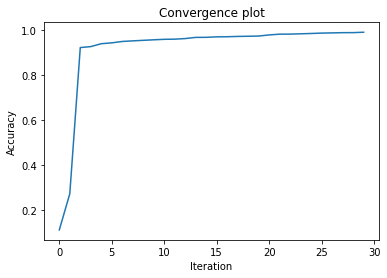

In [29]:
results = study.trials_dataframe()

results['value'].sort_values().reset_index(drop=True).plot()
plt.title('Convergence plot')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')